<center><font size=5> <b> SMU Homework 7 - MSDS7337 - Natural Language Processing </b> </font>
<br><br><br>
<center><font size=4> <b> Spring 2021  Ikenna Nwaogu </b></font> 




<img src="https://cdn.searchenginejournal.com/wp-content/uploads/2020/08/an-introduction-to-natural-language-processing-with-python-for-seos-5f3519eeb8368-760x400.webp"> 
<br>
<p align="center"><font size=4> <b><center> IMDB Movie Review Clustering  </b></font> </p>

### BeautifulSoup Implementation
<br>
Below we used Beautiful soup to grab the main review text from 50 movie links in the "Drama" Genre of the IMDB movie website. For every movies, we took the top positive and negative review. We then use the NTLK tokenizer to tokenize each review. After that we applied POS tagger and then shallow parser/NP chunker to the dictionary. We will then put the chunks in a single list for all reviews. <br><br>
 

In [2]:
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup
from requests import get

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

#url = 'https://www.imdb.com/list/ls095374765/?sort=list_order,asc&st_dt=&mode=grid&page=1&ref_=ttls_ref_gnr&genres=Drama'
url = 'https://www.imdb.com/list/ls095374765/?sort=moviemeter,asc&st_dt=&mode=grid&page=1&ref_=ttls_vw_smp&genres=Drama'
response = get(url)
html_soupMain = BeautifulSoup(response.text, 'html.parser')


In [3]:
movieReview = []
reviewTitle = []
movieTitle = []

##### <br>We will get the remaining 4 movies from the next page(Page 2) and append it to the previous 96. <br> Below picks top positive and negative reviews in a movie review page.

In [4]:
def list_Of_Reviews(website):
    soup = BeautifulSoup(website, 'html.parser')
    # print(soup)
    f = soup.find_all('div', class_='ipl-icon ipl-star-icon')
    f = soup.find_all('span', class_="rating-other-user-rating")#.find('span').text

    idxPos = -1
    idxNeg = -1

    for idx, i in enumerate(f):
        sp = (f[idx].text.split('/'))
        sp = int(sp[0][-2:])
        if sp > 8:
            idxPos = idx
        elif sp < 4:
            idxNeg = idx
    return([idxNeg,idxPos])

Bellow shows how beautifulsoup was able to parse and get the movie title and the review title. We will use both information in displaying the reviews. As stated above we will have 2 reviews per movie, positive and negative reviews. I wonder if the cluster would be able to cluster the reviews of same movie together in one cluster or whether some negative comments would cluster similarly. We also did a lemantization using nltk.

In [5]:
stop_words = set(stopwords.words("english"))
for div in html_soupMain.findAll('div', attrs={'class':'title'}):
    if len(movieReview) > 98:
        break
    else:
        url = 'https://www.imdb.com' + div.find('a')['href'] 
        url = url + 'reviews'
        response = get(url)
        html_soup = BeautifulSoup(response.text, 'html.parser')
        review_containers = html_soup.find_all('div', class_='text show-more__control')
        title_containers = html_soup.find_all( class_='title')
        
        reviewIndex = list_Of_Reviews(response.content)
        reviewList = []

        if reviewIndex[0] == -1 or reviewIndex[1] == -1:
            pass
        else:
            reviewList.append(review_containers[reviewIndex[0]].text)
            reviewList.append(review_containers[reviewIndex[1]].text)
            reviewTitle.append(title_containers[reviewIndex[0]].string + ' -')
            reviewTitle.append(title_containers[reviewIndex[1]].string + ' +')
            movieTitle.append(div.string + ' -')
            movieTitle.append(div.string + ' +')
            count =+ 2
            for i in reviewList:
                review = i.lower()
                #remove punctuation
                review = re.sub('[^a-zA-Z]', ' ', review)
                
                #remove tags
                review = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",review)

                #remove special characters and digits
                review = re.sub("(\\d|\\W)+"," ",review)

                split_text = review.split()
                
                #Lemmatisation
                lem = WordNetLemmatizer()
                split_text = [lem.lemmatize(word) for word in split_text if not word in stop_words and len(word) >2] 
                split_text = " ".join(split_text)
                movieReview.append(split_text)


Each movie title and review title is tagged with a positive or negative in the end so to differentiate each review.

In [6]:
print(len(movieReview))

100


### Vectorize Reviews using TF-IDF
We vectorize the movie review list using tf-idf.

In [7]:
#TF-IDF vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfv = TfidfVectorizer(stop_words = {'english'})#stop_words, ngram_range = (1,1))#transform
vec_text = tfv.fit_transform(movieReview)#returns a list of words.
words = tfv.get_feature_names()

To decide what the number of k clusters, we implore the elbow method which consists of pllotting  different variations as a function of  a certain number of cluster which we would provive. We chose to tryk from 2 to 9.

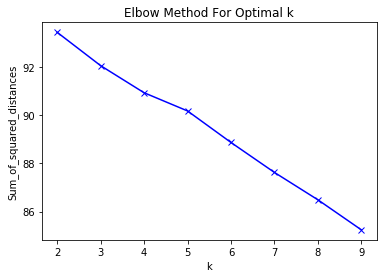

In [8]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
X = vec_text
K = range(2,10)
for k in K:
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Above shows sum of square distance that is slightly straight line but shows a bit of convergeance around 6 so we would use k of 6. We allow k to be altered up to 10 with n_init = 10. we allowed tolerance of 0.001 and max iteration of 200.

In [9]:
import pandas as pd
true_k = 6
model = KMeans(n_clusters=true_k, max_iter=200, n_init=10, n_jobs = -1, tol = 0.001)
model.fit(X)
labels=model.labels_
reviews_cl=pd.DataFrame(list(zip(movieTitle, reviewTitle,labels)),columns=['Movie','Review title','cluster'])
reviews_cl.sort_values(by=['cluster'])


,Movie,Review title,cluster
64,"Batman: The Dark Knight Returns, Part 1 -","Not a good adaptation, regrettably\n -",0
79,Final Score +,Too much for English Viewers\n +,0
55,Deadwood: The Movie +,Daniel Weiss and David Benioff ... Take Note\n +,0
73,Pathfinder +,Insult\n +,0
39,The Twilight Saga: New Moon +,Makes Me Sad\n +,0
...,...,...,...
78,Final Score -,Die hard x sudden death = p** poor\n -,5
60,John Q -,Denzel in Training Day and now in John Q show...,5
27,The Man in the Iron Mask +,A terrific cast is wasted in a dull Dumas ada...,5
6,Glass -,How to break unbreakable\n -,5


In [10]:
common_words = model.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))


0 : movie, love, like, viking, indonesia, moment, something, amazing, idea, patriot
1 : film, movie, see, would, scene, one, washington, good, story, denzel
2 : movie, one, film, watch, seen, battle, time, read, many, give
3 : batman, comic, superman, film, fan, story, punisher, love, movie, relationship
4 : prison, damme, van, kyle, bad, hell, shirt, performance, claude, steel
5 : action, movie, interesting, think, combination, watch, enough, funny, mean, perfect


Above shows some of the common words that were used to cluster.

Cluster: 0
Review Titles
                                Twilight +
                             The Patriot +
                     The Next Three Days +
             The Twilight Saga: New Moon +
                                  Convoy +
                     Deadwood: The Movie +
                             He Got Game -
 Batman: The Dark Knight Returns, Part 1 -
                              Pathfinder +
                             Final Score +
                                 Gundala -
                                 Gundala +
                                Órbita 9 -


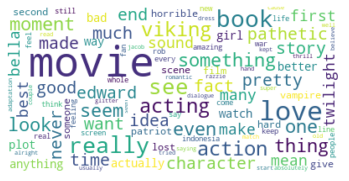

Cluster: 1
Review Titles
                                      Glass +
 Extremely Wicked, Shockingly Evil and Vile -
                                  Immortals +
                            The Hurt Locker -
                            The Hurt Locker +
                                The Patriot -
                                The Aviator -
                                The Aviator +
                               Pearl Harbor -
                               Pearl Harbor +
                                     Flight +
                         The Lost City of Z -
                         The Lost City of Z +
                   The Man in the Iron Mask -
  The Twilight Saga: Breaking Dawn - Part 1 +
                              State of Play -
                              State of Play +
                The Twilight Saga: New Moon -
                                  Malcolm X -
                                  Malcolm X +
                               Body of Lies +
         

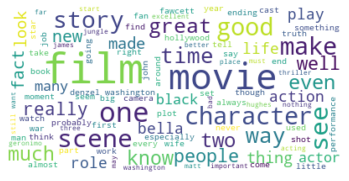

Cluster: 2
Review Titles
                                   Twilight -
                                       Argo -
                                       Argo +
                               Cold Pursuit -
 Extremely Wicked, Shockingly Evil and Vile +
                                  Immortals -
                A Walk Among the Tombstones -
                A Walk Among the Tombstones +
                 The Twilight Saga: Eclipse -
  The Twilight Saga: Breaking Dawn - Part 1 -
                         Enemy at the Gates -
                         Enemy at the Gates +
                               Body of Lies -
                     Brawl in Cell Block 99 -
                     Brawl in Cell Block 99 +
                               Batman: Hush +
                         The Bone Collector +
                                   J. Edgar -
                             Antwone Fisher +
                            Too Big to Fail +
                                All the Way +
         

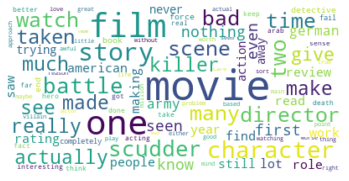

Cluster: 3
Review Titles
                Batman: The Killing Joke +
                     Deadwood: The Movie -
                            Batman: Hush -
 Batman: The Dark Knight Returns, Part 1 +
                      Punisher: War Zone -
                        Batman: Year One -
                        Batman: Year One +
                       Superman/Doomsday -
         Superman/Batman: Public Enemies -
         Superman/Batman: Public Enemies +


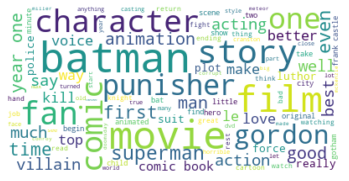

Cluster: 4
Review Titles
 In Hell -
 In Hell +


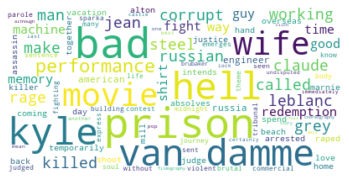

Cluster: 5
Review Titles
               Cold Pursuit +
                      Glass -
        The Next Three Days -
                     Flight -
   The Man in the Iron Mask +
 The Twilight Saga: Eclipse +
                     John Q -
                         IO -
                         IO +
                 Pathfinder -
                Final Score -


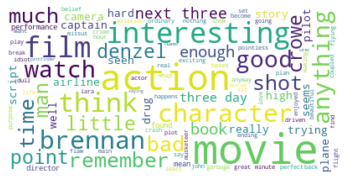

In [11]:
from wordcloud import WordCloud
result={'cluster':labels,'Movie Reviews':movieReview}
result=pd.DataFrame(result)
for k in range(0,true_k):
    s=result[result.cluster==k]
    text=s['Movie Reviews'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    print('Cluster: {}'.format(k))
    print('Review Titles')
    movieTitles=reviews_cl[reviews_cl.cluster==k]['Movie']    
    #reviewTitles=reviews_cl[reviews_cl.cluster==k]['Review title'] 
    print(movieTitles.to_string(index=False))#,reviewTitles.to_string(index=False))
    #print(reviewTitles.to_string(index=False))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

### Hierarchical document clustering (Agnes)
Now we can try to cluster the reviews using hierarchical clustering (AGNES) and then compare it with kmeans cluster. We will then draw a dendrogram and visualize the cluster. First we will get the cosine similarity scores of the vectorized reviews.  

In [12]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(X)
print(dist)

[[-2.22044605e-16  9.85899868e-01  9.89095046e-01 ...  9.77217624e-01
   1.00000000e+00  9.85684239e-01]
 [ 9.85899868e-01  1.11022302e-16  9.65162582e-01 ...  9.51392982e-01
   9.73924604e-01  9.47639272e-01]
 [ 9.89095046e-01  9.65162582e-01  2.22044605e-16 ...  9.33629723e-01
   9.72685512e-01  9.57545189e-01]
 ...
 [ 9.77217624e-01  9.51392982e-01  9.33629723e-01 ...  0.00000000e+00
   9.54733478e-01  9.68170616e-01]
 [ 1.00000000e+00  9.73924604e-01  9.72685512e-01 ...  9.54733478e-01
  -2.22044605e-16  8.98074635e-01]
 [ 9.85684239e-01  9.47639272e-01  9.57545189e-01 ...  9.68170616e-01
   8.98074635e-01  0.00000000e+00]]


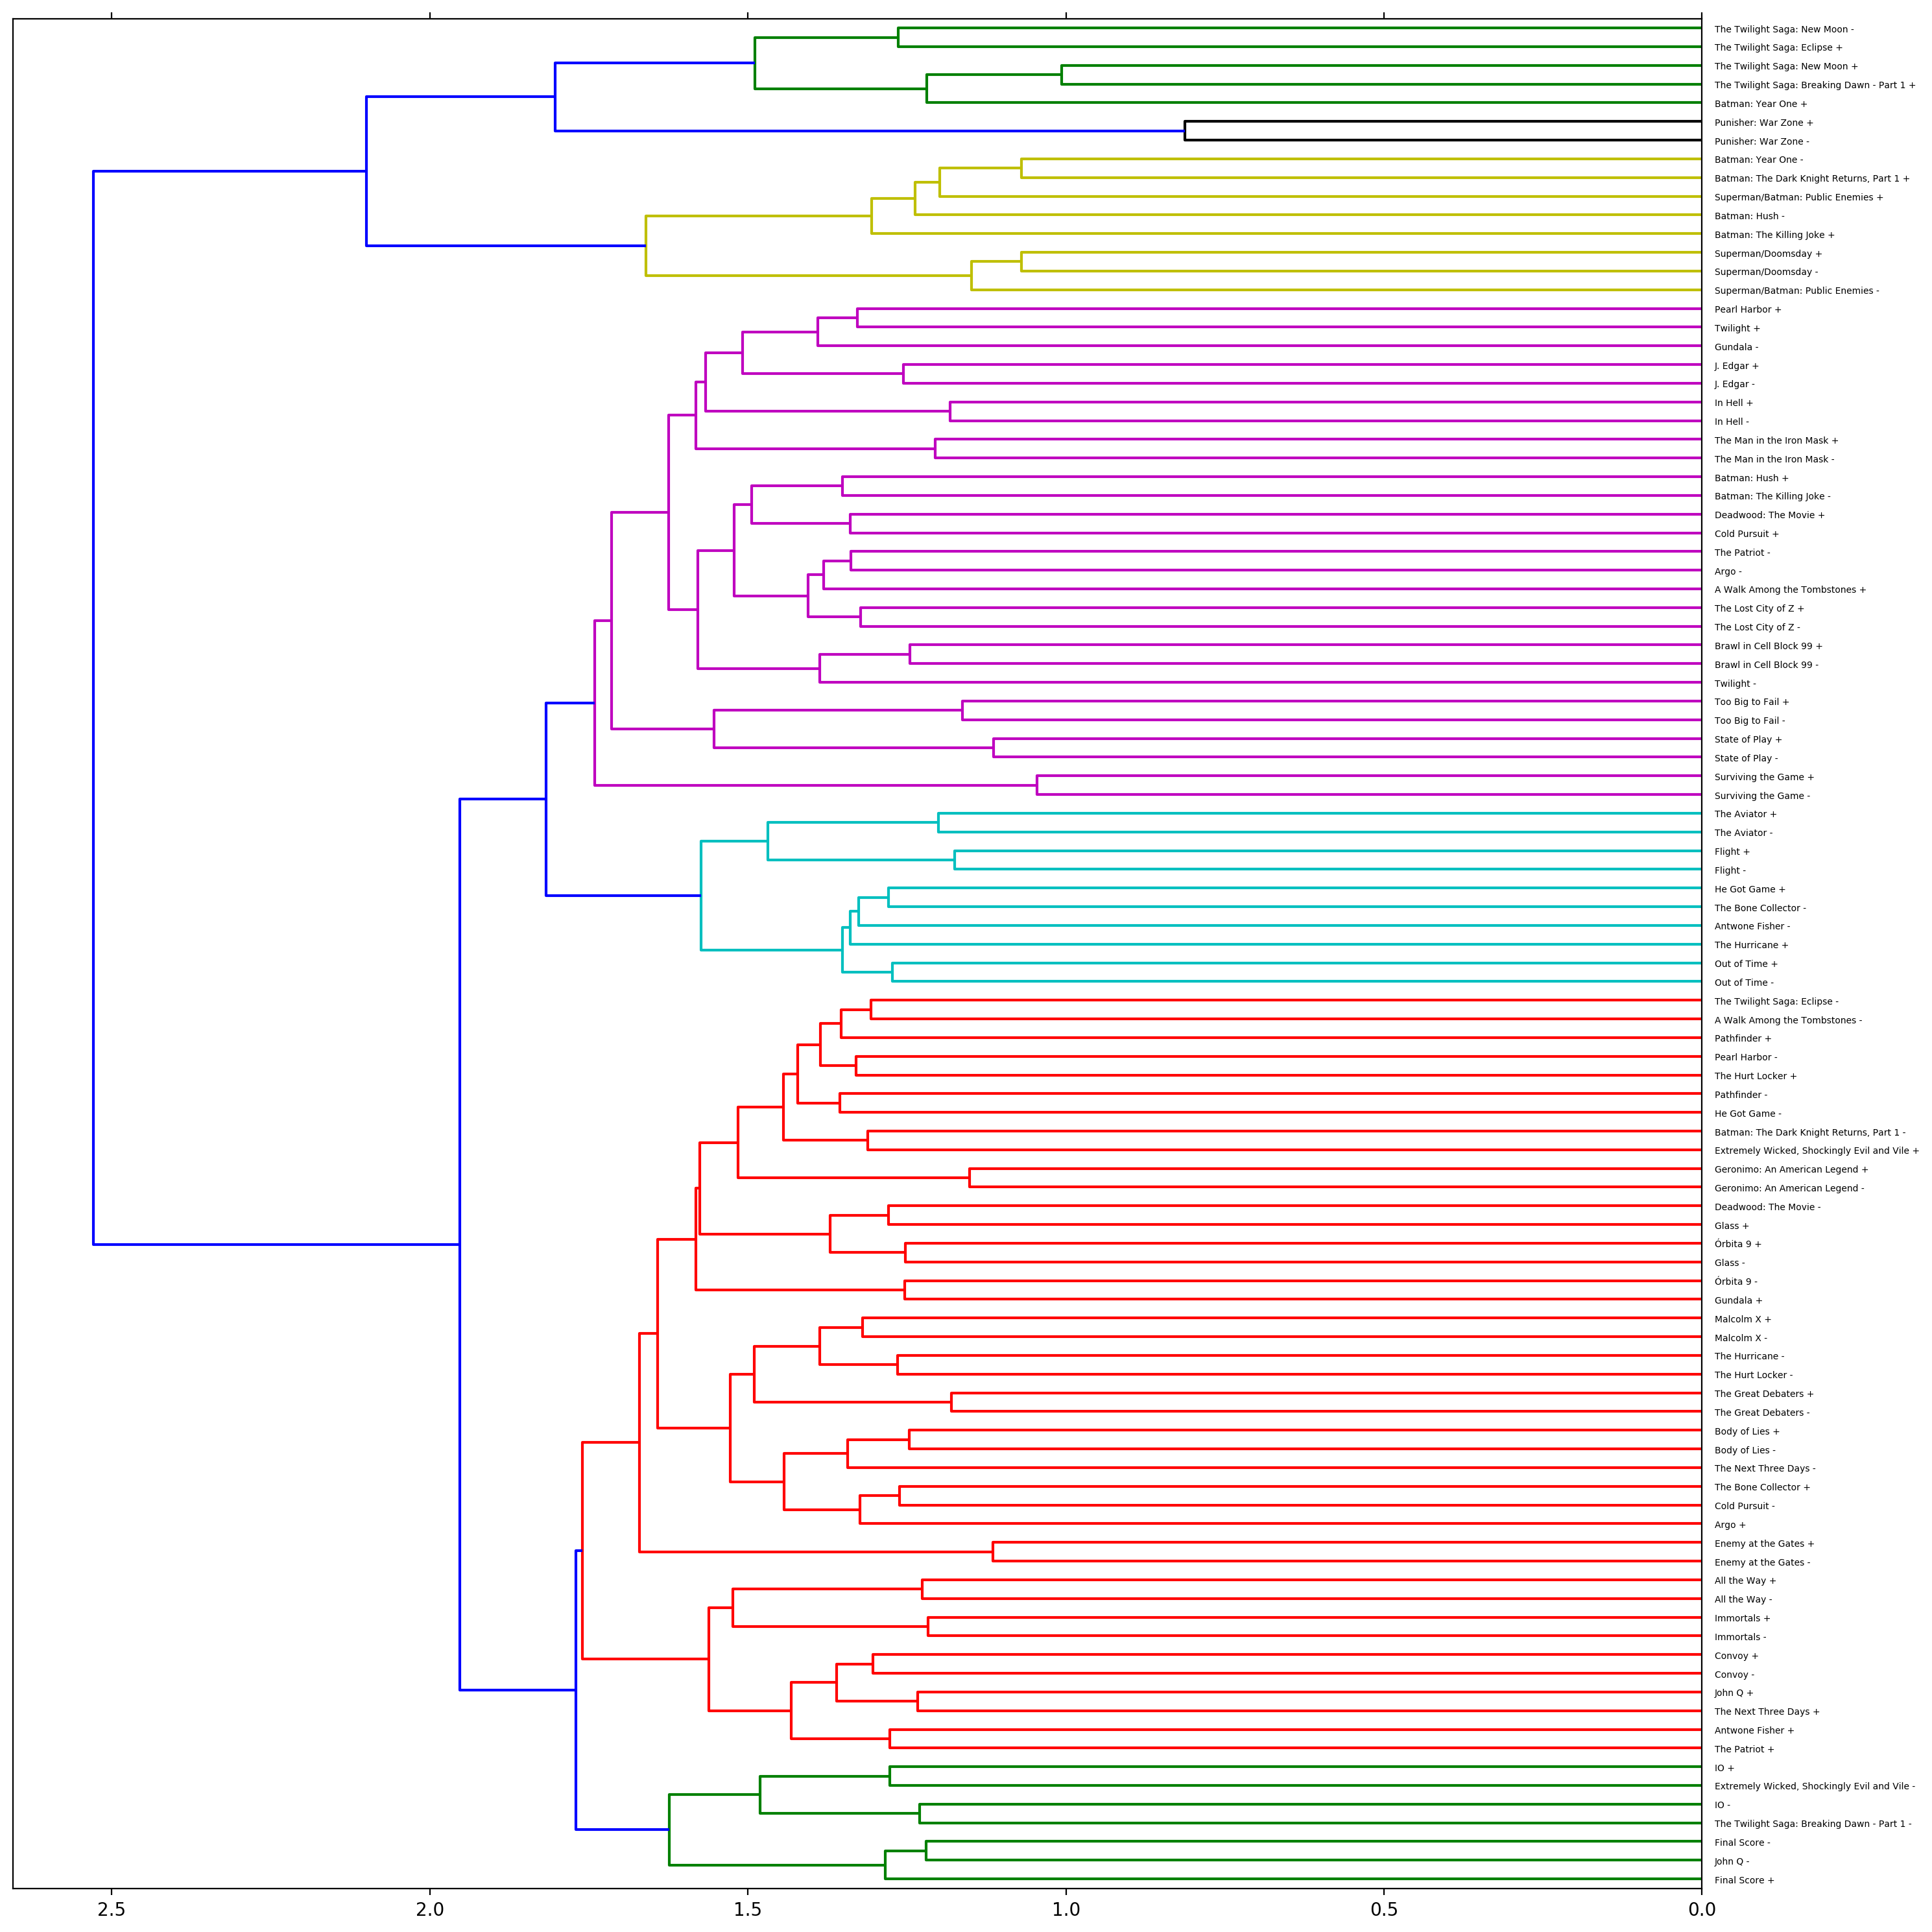

In [13]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 15), dpi = 200) # set size
ax = dendrogram(linkage_matrix, orientation="left", labels=movieTitle);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
#plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

                                                      team
cluster                                                   
1        Twilight -Twilight +Argo -Argo +Cold Pursuit -...


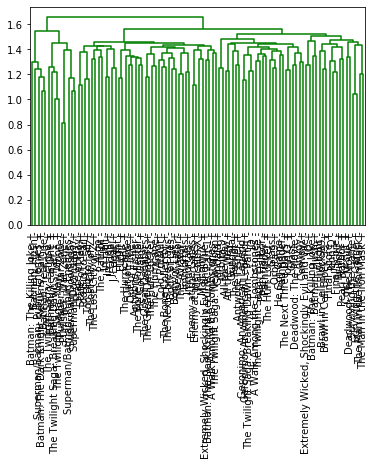

In [20]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
import pandas

# distanceMatrix = pdist(X)
# dend = dendrogram(linkage(distanceMatrix, method='complete'), 
dend = dendrogram(linkage(dist, method='complete'), 
           color_threshold=4, 
           leaf_font_size=10,
           labels=movieTitle)


# assignments = fcluster(linkage(distanceMatrix, method='complete'),4,'distance')
assignments = fcluster(linkage(dist, method='complete'),4,'distance')
cluster_output = pandas.DataFrame({'team': movieTitle, 'cluster':assignments})
# print(cluster_output)

# print(cluster_output.groupby(by=["cluster"]).sum())

In [ ]:
print(cluster_output)

In [21]:
print(cluster_output.groupby(by=["cluster"]).sum())

                                                      team
cluster                                                   
1        Twilight -Twilight +Argo -Argo +Cold Pursuit -...


### Conclusion
Both cluster did somewhat of a good job. The heirarchical method returned 3 primary clusters, with the largest cluster being split into about 3 major subclusters. Both clusters was able to put both some of the negative and the positive reviews of the same moview in one cluster. I preffered the heirarchical because it managed to cluster more similar movies together. Batman and superman movies vs Twilight movies vs the rest if we cut it off on the major clusters. Even when you look closely at the subclusters, some of the reviews from same movies were clustered with same sub of subcluster.